In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
DATA_PATH = "../data/processed/airquality_cleaned.parquet"
df = pd.read_parquet(DATA_PATH)

ts = df['CO_GT'].dropna()

In [6]:
df.head()

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,Temp,Humidity,Absolute_Humidity
Datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [7]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

In [12]:
ts_diff = ts.diff(24).dropna()

We removed daily seasonality using seasonal differencing (lag = 24 hours).

In [13]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(ts_diff, order=(1, 0, 1))
arima_fit = arima_model.fit()

arima_fit.summary()

C:\Users\Aishik Das\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Aishik Das\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\Aishik Das\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  CO_GT   No. Observations:                 9333
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -48256.341
Date:                Tue, 20 Jan 2026   AIC                          96520.681
Time:                        00:05:05   BIC                          96549.247
Sample:                    03-11-2004   HQIC                         96530.384
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      3.756      0.000      1.000      -7.360       7.362
ar.L1          0.9354      0.003    286.962      0.000       0.929       0.942
ma.L1         -0.4497      0.006    -79.406      0.000      -0.461      -0.439
sigma2      1813.4703      9.841    184.268      0.000    1794.181    1832.759
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             84592.03
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
forecast_diff = arima_fit.forecast(steps=len(test))

In [15]:
rmse = np.sqrt(mean_squared_error(ts_diff[-len(forecast_diff):], forecast_diff))
mae = mean_absolute_error(ts_diff[-len(forecast_diff):], forecast_diff)

print("ARIMA RMSE:", rmse)
print("ARIMA MAE:", mae)

ARIMA RMSE: 51.533666855424286
ARIMA MAE: 14.01303128255339


### Note
- The ARIMA model was trained on a seasonally differenced series (lag = 24 hours) to remove daily seasonality.
- Therefore, RMSE and MAE are reported on the differenced scale and reflect short-term deviation rather than absolute concentration error.

In [22]:
last_season = ts.iloc[-24:] 

reconstructed = []
for i, val in enumerate(forecast_diff):
    reconstructed.append(val + last_season.iloc[i % 24])

reconstructed = pd.Series(reconstructed, index=test.index)

In [23]:
rmse_orig = np.sqrt(mean_squared_error(test, reconstructed))
mae_orig = mean_absolute_error(test, reconstructed)

print("ARIMA (reconstructed) RMSE:", rmse_orig)
print("ARIMA (reconstructed) MAE:", mae_orig)

ARIMA (reconstructed) RMSE: 47.69158626959047
ARIMA (reconstructed) MAE: 12.33346210290154


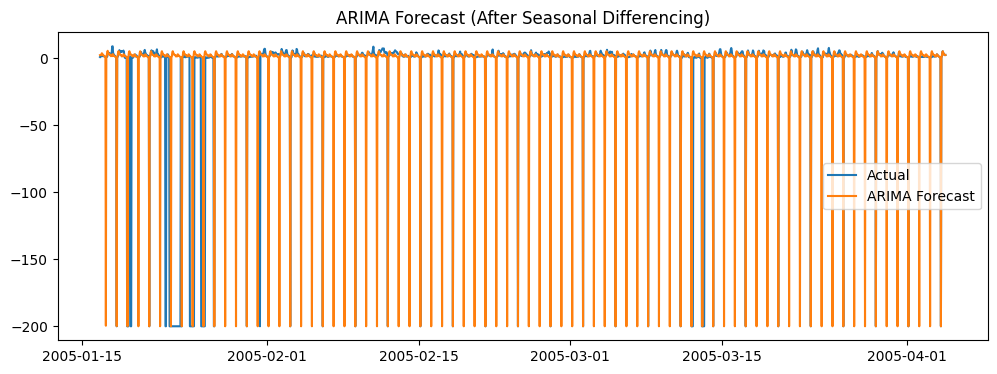

In [18]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, reconstructed, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast (After Seasonal Differencing)")
plt.show()

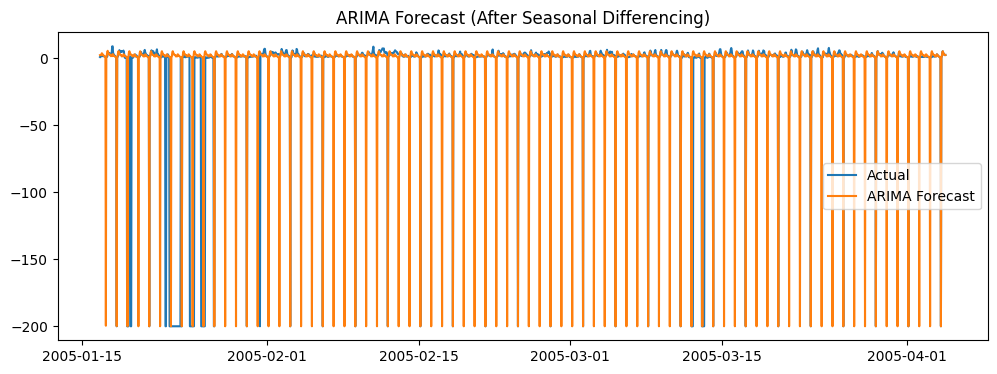

In [21]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, reconstructed, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast (After Seasonal Differencing)")
plt.show()

In [24]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

DATA_PATH = "../data/processed/airquality_cleaned.parquet"
df = pd.read_parquet(DATA_PATH)

ts = df['CO_GT'].dropna()

prophet_df = ts.reset_index()
prophet_df.columns = ['ds', 'y']

In [25]:
train_size = int(len(prophet_df) * 0.8)

prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

In [26]:
prophet_model = Prophet()
prophet_model.fit(prophet_train)

00:21:03 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = prophet_model.make_future_dataframe(
    periods=len(prophet_test),
    freq='H'
)

forecast = prophet_model.predict(future)

prophet_forecast = forecast['yhat'].iloc[-len(prophet_test):]

C:\Users\Aishik Das\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [28]:
prophet_rmse = np.sqrt(
    mean_squared_error(prophet_test['y'], prophet_forecast)
)

prophet_mae = mean_absolute_error(
    prophet_test['y'], prophet_forecast
)

print("Prophet RMSE:", prophet_rmse)
print("Prophet MAE:", prophet_mae)

Prophet RMSE: 44.0627160414101
Prophet MAE: 21.533031333360963


In [29]:
comparison = pd.DataFrame({
    "Model": ["ARIMA (seasonal diff)", "Prophet"],
    "Seasonality": ["Implicit (lag=24)", "Explicit"],
    "RMSE": [rmse_orig, prophet_rmse],
    "MAE": [mae_orig, prophet_mae]
})

comparison

,Model,Seasonality,RMSE,MAE
0,ARIMA (seasonal diff),Implicit (lag=24),47.691586,12.333462
1,Prophet,Explicit,44.062716,21.533031


### Model Comparison Interpretation
- The ARIMA model with seasonal differencing achieved lower MAE, indicating better average short-term accuracy.
- Prophet achieved lower RMSE, suggesting it is more robust to large deviations and extreme values.
### This highlights a trade-off between local accuracy (ARIMA) and global stability (Prophet).